In [3]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax; self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2
        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()
    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()
    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

In [7]:
phantom = np.load(os.path.join(xg.data_path,'phantoms/segemented_head_phantom.npy'))
det = 'CWO'
spectrum_file = 'Al_spectrum_6'

angles = np.linspace(0,2*np.pi,360)

In [8]:
s = xg.Spectrum()

energies = []
fluence = []

with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
    for line in f:
        energies.append(float(line.split()[0]))
        fluence.append(float(line.split()[1]))

s.x = np.array(energies)*1000  # to keV
s.y = np.array(fluence)

In [9]:
dump_files = os.path.join(
    xg.data_path, "Detectors", det, '*phsp.npy')
energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

kernel, kernels = xg.get_kernel(
                        s, dump_files, energy_deposition_file)

energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

energies = s.x
fluence = s.y
deposition_efficiency_file = energy_deposition_file

(17,) (17,)


In [10]:
phantom_mapping = ['air','water','bone','brain','bone']

# Don't want to look for zeros
useful_phantom = phantom != 0

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

deposition_summed = np.array([    0.        ,  2395.25927928,  3434.7986552 ,  4416.62822646,
    5373.00952021,  6067.40938147,  6955.18365258,  7901.50699458,
    8860.76810654, 20457.403665  , 22916.6726841 , 26069.46417263,
   29726.25290966, 31589.13314065, 49335.93687135])

masks = np.zeros([len(phantom_mapping)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
mapping_functions = []

# Get the mapping functions for the different tissues
for ii in range(1,len(phantom_mapping)):

    mapping_functions.append(xg.get_mu(phantom_mapping[ii]))
    masks[ii-1] = phantom == ii

geo = tigre.geometry_default(high_quality=False)

# angles = np.linspace(0, 0, 1, dtype=np.float32)

energy = 100

phantom2 = phantom.copy().astype(np.float32)

In [11]:
%%time

proj = []

for energy in original_energies_keV[1:]:
    for ii in range(0,len(phantom_mapping)-1):

        phantom2[masks[ii].astype(bool)] = mapping_functions[ii](energy)

    proj.append(np.squeeze(tigre.Ax(phantom2,geo,angles)))

proj_filt = proj.copy()

CPU times: user 2.44 s, sys: 685 ms, total: 3.13 s
Wall time: 3.17 s


<IPython.core.display.Javascript object>


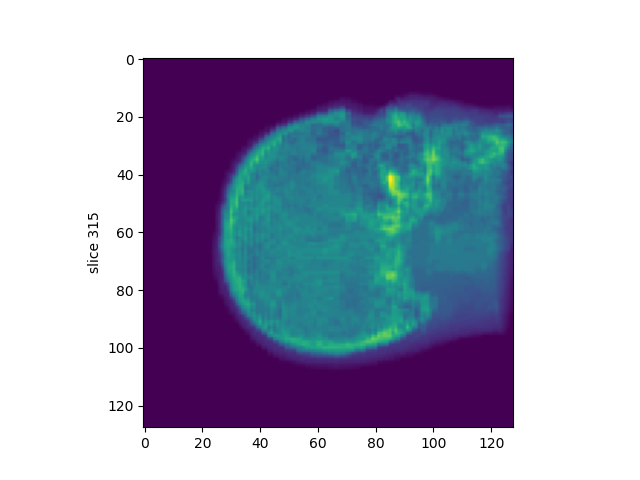

In [13]:
fig, ax = plt.subplots(1, 1)

X = np.transpose(np.array(proj[0][:][:]),[2,1,0])

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [11]:
out = []

for kk in range(len(angles)):
    for ii in range(len(original_energies_keV)-1):

        proj_filt[ii] = fftconvolve(proj[ii][kk],kernels[ii+1], mode = 'same')

    fluence_small = np.interp(original_energies_keV[1:],np.array(energies)*1000, fluence)

    weights_small = fluence_small*deposition_summed

    out.append(np.array(proj_filt).T@weights_small)

<IPython.core.display.Javascript object>


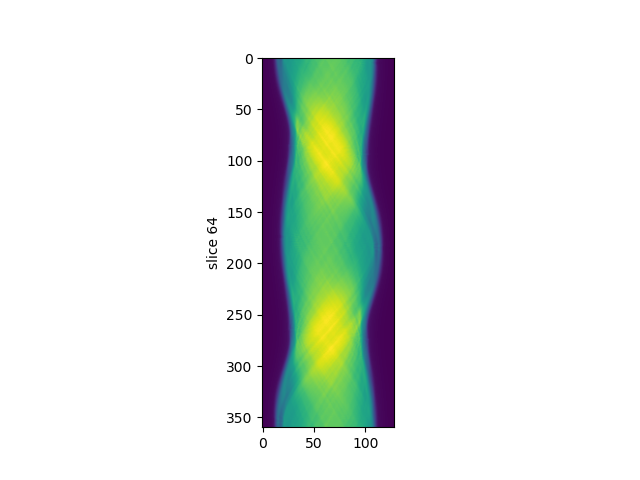

In [12]:
fig, ax = plt.subplots(1, 1)

X = np.array(out)

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [13]:
img = tigre.algorithms.FDK(
    np.transpose(np.array(out),[0,2,1]), geo, angles)

<IPython.core.display.Javascript object>


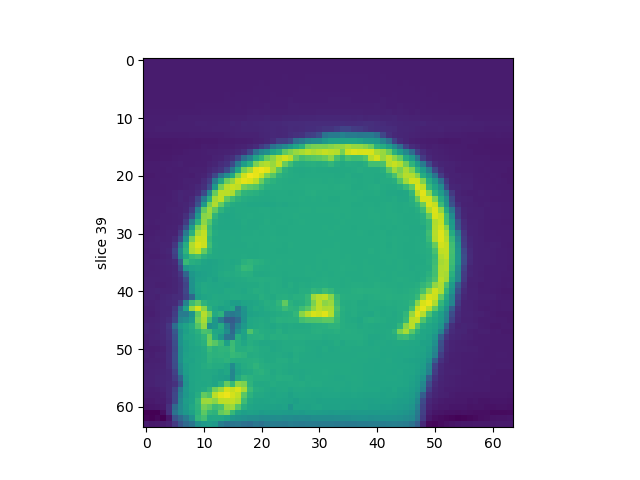

In [14]:
fig, ax = plt.subplots(1, 1)

X = np.array(img)

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

# Equivalent fastCAT

In [17]:
projs_xg = xg.return_projs(phantom,kernels,energies,fluence,angles,geo)

img_xg = tigre.algorithms.FDK(
    np.transpose(np.array(projs_xg),[0,2,1]), geo, angles)

fig, ax = plt.subplots(1, 1)

X = np.array(img_xg)

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [22]:
kernel